# Reddit Aggregate Stats Visualizations

## Imports & PRAW Login

* PRAW: Used to request Reddit data via Reddit API
* Pandas: Used to handle data via dataframes
* Datetime: Used to handle datetime objects
* Seaborn: Used to create visualizations
* Matplotlib: Used to create visualizations
* Config: Contains confidential information

In [17]:
import praw
from praw.models import MoreComments
import pandas as pd
import numpy as np
from pmaw import PushshiftAPI
import datetime as dt
from datetime import datetime
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import config

In [18]:
reddit = praw.Reddit(
    client_id=config.client_id,
    client_secret=config.client_secret,
    password=config.password,
    user_agent=config.user_agent,
    username=config.username,
)

## Importing & Collecting Data

In [19]:
#reddits contains show names, primary subreddit, and imdb link
reddits = pd.read_csv('raw/reddit_shows.csv')
reddits.columns = ['Show', 'Sub']
reddits['Normal_Sub'] = reddits['Sub'].str.replace("r/",'').str.lower()

#on_app contains all shows available on the bantr app, merged with reddits df
on_app = pd.read_csv('raw/current_on_app.csv')
reddits = reddits.merge(on_app, how='right', on='Show')
del on_app['Link']
on_app.columns = ['Date']

#actives contains Active Users data from 4/05/2023 to 4/12/2023 collected via autoscrape.py
actives = pd.read_csv('raw/Actives412.csv')
actives = actives.merge(on_app, how='right', on='Date')
actives = actives.T
actives.columns = actives.iloc[0]
actives = actives.iloc[1:]
actives.index = pd.to_datetime(actives.index)
for index in actives.index:
    converted = index.strftime('%M')
    if converted == '00':
        actives = actives.drop(index)

#aggdict initialized to contain aggergate statistics
aggdict = {}

In [20]:
#set styles for visualizations
sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=30)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)          # controls default text sizes

In [21]:
#uses PRAW to gather current subscriber numbers from a subreddit
def getSubscribers(row):
    try:
        subreddit = reddit.subreddit(row['Normal_Sub'])
        return subreddit.subscribers
    except:
        return 0

In [22]:
#apply getSubscribers to reddits df to collect current subscribers on Reddit for each show
reddits['Subscribers'] = reddits.apply(lambda row: getSubscribers(row), axis=1) 

In [23]:
#Save current date and time and aggregate subreddit subscribers across all subreddits
currentDateAndTime = datetime.now()
currentTime = currentDateAndTime.strftime("%m/%d/%Y, %H:%M:%S")
aggdict[f'Total Subscribers ({currentTime})'] = reddits['Subscribers'].sum() 

In [24]:
#Import subreddit comment data from past year
comments = pd.read_csv('raw/comments_past_year.csv')
comments = comments[:-1]
comments['Date'] = comments['Unnamed: 0'].str.replace("20:00", '')
del comments['Unnamed: 0']
comments['Date'] = pd.to_datetime(comments['Date'])
first_com = comments.pop('Date')
comments = comments.interpolate()
comments = comments.fillna(0)
comments.insert(0,'Date', first_com)

**_Note_:** Comment data was collected from [Subreddit Stats](https://subredditstats.com/)

In [25]:
#aggregate comment data across all subreddits for past year
aggdict['Total Comments (Annual)'] = comments.loc[:, comments.columns != 'Date'].sum().sum()

In [26]:
#Aggregate total active users across all subreddits for past week
aggdict['Total Active Users (Weekly)'] = actives.sum().sum()

In [27]:
print(aggdict)

{'Total Subscribers (09/14/2023, 13:41:21)': 8982648, 'Total Comments (Annual)': 2984055.0, 'Total Active Users (Weekly)': 1267879}


## Aggregate Visualizations

Bar graph used to display an estimated Total Adressable Market by observing overall subscribers on Reddit to bantrable show subreddits and show the discrepency between overall users and active users through visualizing total comments in the past year and total active users in the past week.

_Note_: Bantrable show - show that is available on Bantr app

[Text(0.5, 1.0, 'Bantrable Show Subreddit Totals'),
 Text(0, 0.5, 'Value (Millions)')]

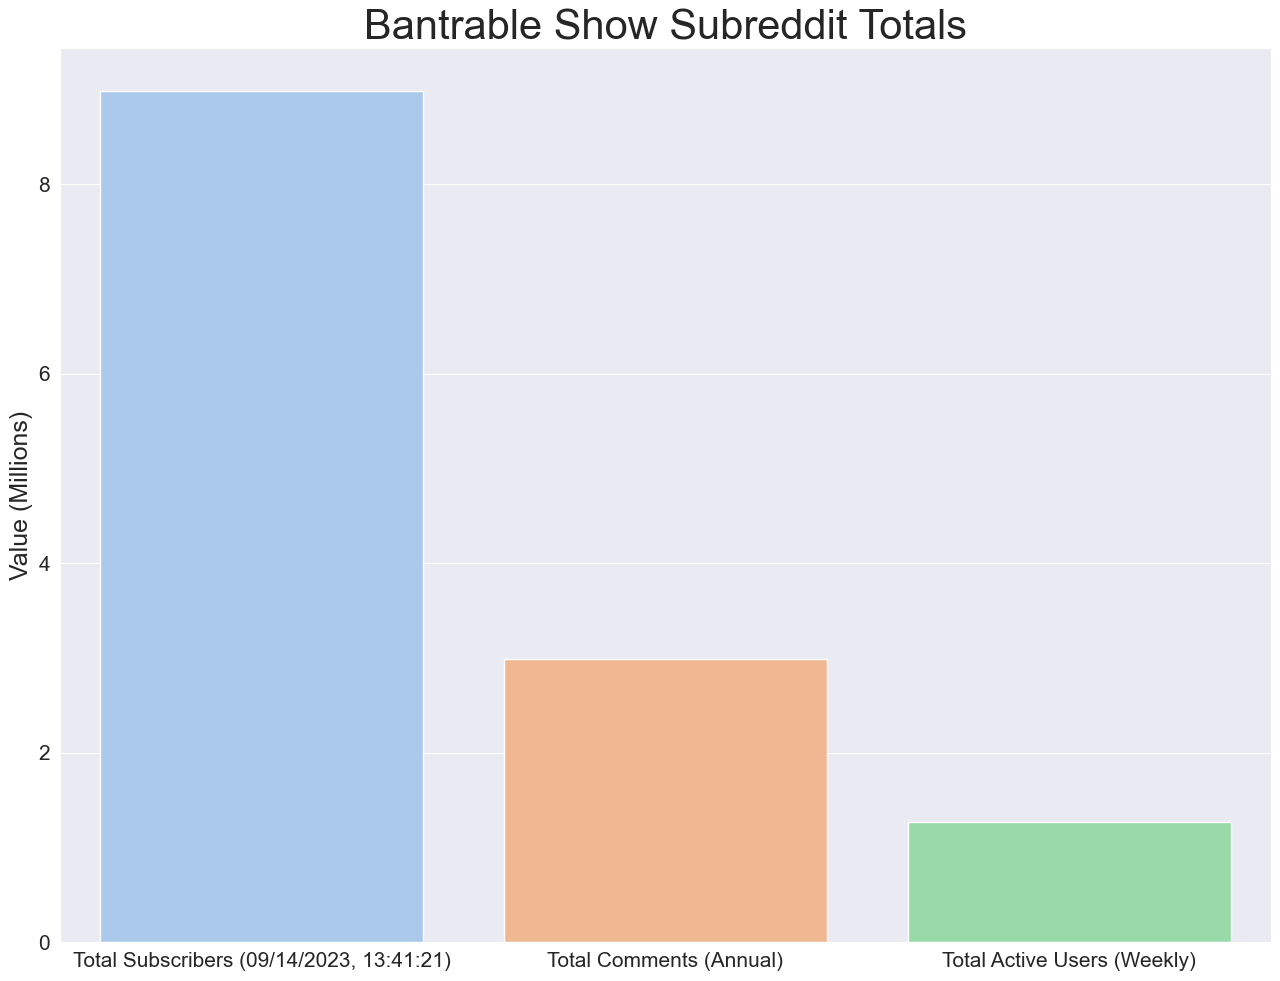

In [28]:
sns.set_palette('pastel')
keys = list(aggdict.keys())
vals = [round(aggdict[k]/1000000, 4) for k in keys]
plt.figure(figsize=(13,10), tight_layout=True)
ax = sns.barplot(x=keys, y=vals)
ax.set(title='Bantrable Show Subreddit Totals', ylabel='Value (Millions)')

### Suggestions

Based on statistics seen in other visualizations, it was concluded that the most beneficial shows to add to the app would be Game of Thrones, Survivor, and The Bachelorette.

Thus, a stacked bar graph is created to display how adding these shows would effect the aggregate statistics.

In [30]:
#reinitialize reddits df, on_app df, and actives df adding the three shows
reddits = pd.read_csv('raw/reddit_shows.csv')
reddits.columns = ['Show', 'Sub']
reddits['Normal_Sub'] = reddits['Sub'].str.replace("r/",'').str.lower()
on_app = pd.read_csv('raw/on_app_additions.csv')
reddits = reddits.merge(on_app, how='right', on='Show')
del on_app['Link']
on_app.columns = ['Date']
actives = pd.read_csv('raw/Actives412.csv')
actives = actives.merge(on_app, how='right', on='Date')
actives = actives.T
actives.columns = actives.iloc[0]
actives = actives.iloc[1:]
actives.index = pd.to_datetime(actives.index)
for index in actives.index:
    converted = index.strftime('%M')
    if converted == '00':
        actives = actives.drop(index)
aggdict = {}

In [32]:
#reinitialize comments df with three new shows
comments = pd.read_csv('raw/comments_past_year_addition.csv')
comments = comments[:-1]
comments['Date'] = comments['Unnamed: 0'].str.replace("20:00", '')
del comments['Unnamed: 0']
comments['Date'] = pd.to_datetime(comments['Date'])
first_com = comments.pop('Date')
comments = comments.interpolate()
comments = comments.fillna(0)
comments.insert(0,'Date', first_com)

In [33]:
#reinitialize subscriber column of reddits df with three new shows
reddits['Subscribers'] = reddits.apply(lambda row: getSubscribers(row), axis=1) 

In [34]:
#separate three new shows into own column in new df in order to create stacked bar graph
active_addition = actives[['Game of Thrones', 'Survivor', 'The Bachelorette']].sum().sum()
subs_addition = reddit.subreddit('gameofthrones').subscribers + reddit.subreddit('survivor').subscribers + reddit.subreddit('thebachelor').subscribers
comments_addition = comments[['Game of Thrones', 'Survivor', 'The Bachelorette']].sum().sum()

stacked_df = pd.DataFrame()
stacked_df['Statistic'] = [f'Total Subscribers ({currentTime})', 'Total Comments (Annual)', 'Total Active Users (Weekly)']
stacked_df['Total'] = [reddits['Subscribers'].sum(), comments.loc[:, comments.columns != 'Date'].sum().sum(), actives.sum().sum()]
stacked_df['Game of Thrones, Survivor, The Bachelorette'] = [subs_addition, comments_addition, active_addition]
stacked_df['Total'] = stacked_df['Total']/1000000
stacked_df['Game of Thrones, Survivor, The Bachelorette'] = stacked_df['Game of Thrones, Survivor, The Bachelorette']/1000000


/var/folders/3v/866x8bfs7hb47f11mt9d5vdc0000gn/T/ipykernel_70403/3734239524.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  bar2 = sns.barplot(x="Statistic", y="Game of Thrones, Survivor, The Bachelorette", data=stacked_df, ci=None,  color='darkblue')


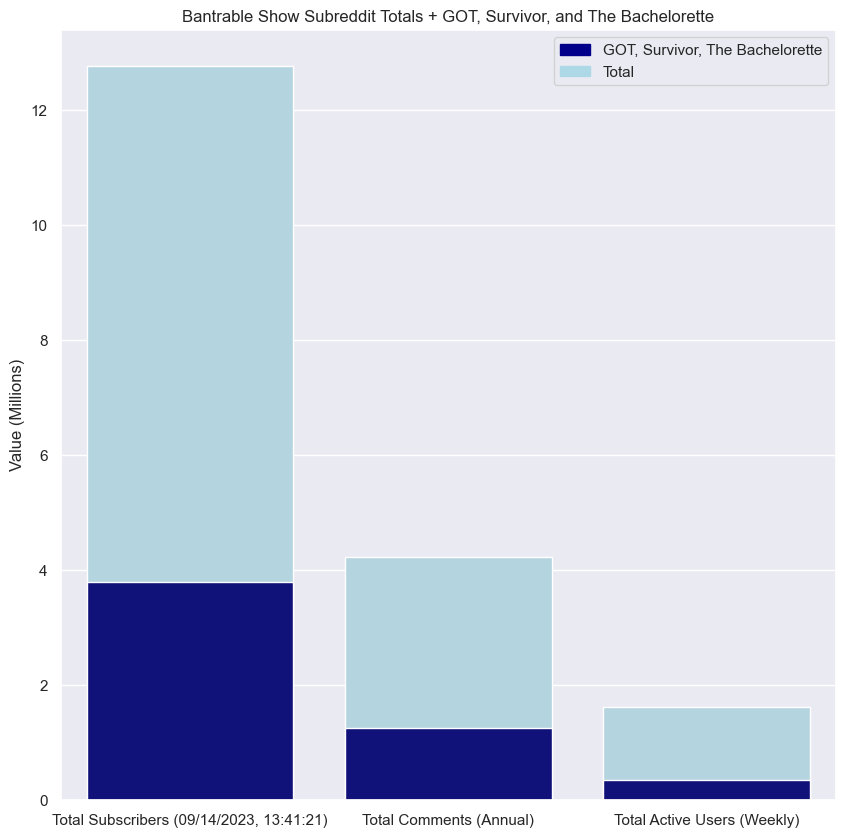

In [36]:
sns.set(style="darkgrid")

# set the figure size
plt.figure(figsize=(10, 10))

# top bar -> sum all values(current shows + new shows) to find y position of the bars

# bar chart 1 -> top bars (current shows)
bar1 = sns.barplot(x="Statistic",  y="Total", data=stacked_df, color='lightblue')

# bar chart 2 -> bottom bars (new shows)
bar2 = sns.barplot(x="Statistic", y="Game of Thrones, Survivor, The Bachelorette", data=stacked_df, ci=None,  color='darkblue')

# add legend
top_bar = mpatches.Patch(color='darkblue', label='GOT, Survivor, The Bachelorette')
bottom_bar = mpatches.Patch(color='lightblue', label='Total')
plt.legend(handles=[top_bar, bottom_bar])
bar1.set(title = 'Bantrable Show Subreddit Totals + GOT, Survivor, and The Bachelorette', ylabel='Value (Millions)', xlabel='')
# show the graph
plt.show()